## Toxic: KMC

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.utils import shuffle

In [2]:
df = pd.read_pickle('../data/toxictrain.pkl')
print(df.shape)
df.head()

(159571, 18)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,rating,comment_text_s,comment_text_f,token_clean,sent_token,polarity_sentence,polarity_comment,polarity_comment_s,word_count,polarity_mean
idx,,,,,,,,,,,,,,,,,,
3a4c7758fad18de3,3a4c7758fad18de3,", I hope your retarded kids get anal raped and...",1,1,1,1,1,1,6,", I hope your retarded kids get anal raped and...",", hope retarded kids get anal raped murdered h...","[i, hope, your, retarded, kids, get, anal, rap...","[, I hope your retarded kids get anal raped an...","(-0.6, 1.0, -0.018750000000000003, [-0.4, -0.4...",0.00,0.00,94,-0.018750
24d2b50726b67167,24d2b50726b67167,I am going to murder ZimZalaBim ST47 for being...,1,1,1,1,1,1,6,I am going to murder ZimZalaBim ST47 for being...,", hope retarded kids get anal raped murdered h...","[i, am, going, to, murder, zimzalabim, st47, f...",[I am going to murder ZimZalaBim ST47 for bein...,"(-1.0, -1.0, -1.0, [-1.0])",0.00,0.00,12,-1.000000
c586b7a2fd575b13,c586b7a2fd575b13,"Shut up you asswipe, we don't care. I'll decap...",1,1,1,1,1,1,6,"Shut up you asswipe, we don't care. I'll decap...",", hope retarded kids get anal raped murdered h...","[shut, up, you, asswipe, we, dont, care, ill, ...","[Shut up you asswipe, we don't care., I'll dec...","(-0.2, 0.0, -0.07555555555555557, [0.0, -0.177...",-0.25,-0.25,24,-0.075556
77d84b1321c22d9a,77d84b1321c22d9a,"LGBT \n\nyou little fuck , are you a fag , tha...",1,1,1,1,1,1,6,"LGBT \n\nyou little fuck , are you a fag , tha...",", hope retarded kids get anal raped murdered h...","[lgbt, you, little, fuck, are, you, a, fag, th...","[LGBT \n\nyou little fuck , are you a fag , th...","(-0.17750000000000005, 0.0, -0.088750000000000...",0.00,0.00,56,-0.088750
1368c10281978876,1368c10281978876,"You're a stupid cunt \n\nFuck you dumb arse, y...",1,1,1,1,1,1,6,"You're a stupid cunt \n\nFuck you dumb arse, y...",", hope retarded kids get anal raped murdered h...","[youre, a, stupid, cunt, fuck, you, dumb, arse...","[You're a stupid cunt \n\nFuck you dumb arse, ...","(-0.41250000000000003, -0.41250000000000003, -...",0.00,0.00,59,-0.412500


In [3]:
def get_cluster_centers(X, labels, k_num):
    CC_list = []
    for k in range(k_num):
        # get the mean coordinates of each cluster
        CC_list.append(np.mean(X[labels == k], axis = 0))
    return CC_list

# for each cluster substract the mean from each data point to get the error
# then get the magnitude of each error, square it, and sum it
def get_SSE(X, labels):
    k_num = len(np.unique(labels))
    CC_list = get_cluster_centers(X, labels, k_num)
    CSEs = []
    for k in range(k_num):
        # for each cluster of k we get the coordinates of how far off each point is to the cluster
        error_cords = X[labels == k] - CC_list[k]
        # square the coordinates and sum to get the magnitude squared
        error_cords_sq = error_cords ** 2
        error_mag_sq = np.sum(error_cords_sq, axis = 1)
        # since we already have the magnitude of the error squared we can just take the sum for the cluster
        CSE = np.sum(error_mag_sq)
        CSEs.append(CSE)
    # sum each cluster's sum of squared errors
    return sum(CSEs)

## Dataframe A: all rating > 0 included

In [4]:
# DOWNSAMPLING: to prevent kernel crashing
df_t = df[df['rating']>0]
df_nt = df[df['rating']==0]
df_nt = shuffle(df_nt)
df_nt = df_nt[-17000:] # 16225 with rating > 0 
print(df_t.shape,df_nt.shape)
df_A = pd.concat([df_t,df_nt])
df_0 = df_A[df_A['rating']==0]
df_1 = df_A[df_A['rating']>0]
print(df_A.shape)

(16225, 18) (17000, 18)
(33225, 18)


In [5]:
count_vect = CountVectorizer()
X_A = count_vect.fit_transform(df_A.comment_text)
X_A.shape

(33225, 66464)

In [6]:
SSEs = []
Sil_coefs = []
for k in range(2,20):
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(X_A)
    labels = km.labels_
    Sil_coefs.append(silhouette_score(X_A, labels, metric='euclidean'))
    SSEs.append(km.inertia_) 

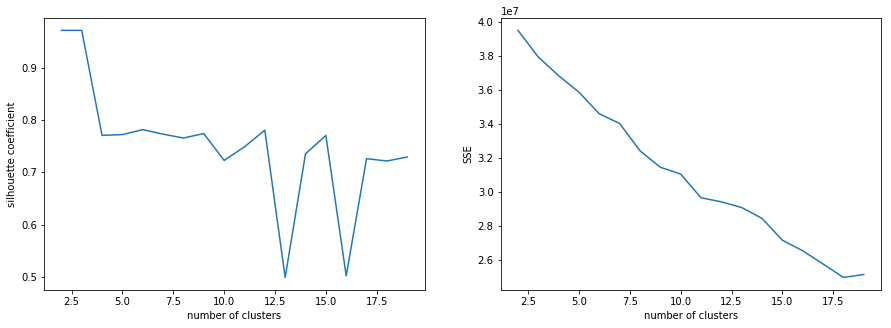

In [7]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True)
k_clusters = range(2,20)
ax1.plot(k_clusters, Sil_coefs)
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('silhouette coefficient')

# plot here on ax2
ax2.plot(k_clusters, SSEs)
ax2.set_xlabel('number of clusters')
ax2.set_ylabel('SSE');

In [8]:
km = KMeans(n_clusters=13)
km.fit(X_A)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=13, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [9]:
mu_digits = km.cluster_centers_
mu_digits.shape

(13, 66464)

## Dataframe B: All samples downsized and randomized equally

In [4]:
df_B = shuffle(df)
df_B = df[-30000:]

In [ ]:
count_vect = CountVectorizer()
X_B = count_vect.fit_transform(df_B.comment_text_s)
X_B.shape

(30000, 44471)

In [ ]:
SSEs = []
Sil_coefs = []
for k in range(2,20):
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(X_B)
    labels = km.labels_
    Sil_coefs.append(silhouette_score(X_B, labels, metric='euclidean'))
    SSEs.append(km.inertia_) 

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True)
k_clusters = range(2,20)
ax1.plot(k_clusters, Sil_coefs)
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('silhouette coefficient')

# plot here on ax2
ax2.plot(k_clusters, SSEs)
ax2.set_xlabel('number of clusters')
ax2.set_ylabel('SSE');
plt.savefig('charts/KMCsilhouetteSSE_3.png')

In [ ]:
km = KMeans(n_clusters=13)
km.fit(X_B)

In [ ]:
mu_digits = km.cluster_centers_
mu_digits.shape

In [ ]:
df_B = shuffle(df)
df_B = df[-20000:]
count_vect = CountVectorizer()
X_B = count_vect.fit_transform(df_B.comment_text)
print(X_B.shape)
SSEs = []
Sil_coefs = []
for k in range(2,20):
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(X_B)
    labels = km.labels_
    Sil_coefs.append(silhouette_score(X_B, labels, metric='euclidean'))
    SSEs.append(km.inertia_) 
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True)
k_clusters = range(2,20)
ax1.plot(k_clusters, Sil_coefs)
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('silhouette coefficient')

# plot here on ax2
ax2.plot(k_clusters, SSEs)
ax2.set_xlabel('number of clusters')
ax2.set_ylabel('SSE');
plt.savefig('charts/KMCsilhouetteSSE_2.png')

In [ ]:
km = KMeans(n_clusters=6)
km.fit(X_B)

In [ ]:
mu_digits = km.cluster_centers_
print(mu_digits)